In [5]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import sys
sys.path.append('../')

In [6]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from clearml import Task
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, ModelSummary
from torch import nn
from torch.utils.data import DataLoader
from transformers import BertConfig, BertModel

from src.datasets import MaskedLMDataset, MaskedLMPredictionDataset, PaddingCollateFn
from src.models import BERT4Rec
from src.modules import SeqRec

from src.metrics import Evaluator
from src.postprocess import preds2recs
from src.preprocess import add_time_idx, filter_items, filter_users
from src.utils import extract_validation_history

from sklearn.model_selection import train_test_split

## Load data

In [3]:
# data_path='../data/ml-1m.csv'
data_path='../data/ml-20m.csv'

data = pd.read_csv(data_path)
data = add_time_idx(data)

train = data[data.time_idx_reversed >= 10]
test = data[data.time_idx_reversed < 10]

users_validation, users_test = train_test_split(
    test.user_id.unique(), test_size=0.5, random_state=42)
validation = test[test.user_id.isin(users_validation)]
test = test[test.user_id.isin(users_test)]

train = add_time_idx(train)
validation = add_time_idx(validation)
test = add_time_idx(test)

train.item_id = train.item_id + 1
validation.item_id = validation.item_id + 1
test.item_id = test.item_id + 1

train2 = train[train.user_id.isin(users_validation)]
validation2 = validation[validation.time_idx == 0]
validation_full = pd.concat([train2, validation2])
validation_full = add_time_idx(validation_full)

## Dataloaders

In [4]:
MAX_LENGTH = 128
MLM_PROBABILITY = 0.2

VALIDATION_SIZE = 2000
# VALIDATION_SIZE = None

BATCH_SIZE = 64
TEST_BATCH_SIZE = 256
NUM_WORKERS = 8

In [5]:
train_dataset = MaskedLMDataset(train, max_length=MAX_LENGTH,
                                mlm_probability=MLM_PROBABILITY,
                                force_last_item_masking_prob=0)

validation_users = validation_full.user_id.unique()
if VALIDATION_SIZE and (VALIDATION_SIZE < len (validation_users)):
    np.random.seed(42)
    validation_users = np.random.choice(validation_users, size=VALIDATION_SIZE, replace=False)
eval_dataset = MaskedLMPredictionDataset(validation_full[validation_full.user_id.isin(validation_users)],
                                         max_length=MAX_LENGTH, validation_mode=True)

collate_fn = PaddingCollateFn()

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())
eval_loader = DataLoader(
    eval_dataset, batch_size=TEST_BATCH_SIZE,
    shuffle=False, num_workers=NUM_WORKERS,
    collate_fn=PaddingCollateFn())

In [17]:
batch = next(iter(train_loader))
print(batch['input_ids'].shape)

torch.Size([64, 128])


## Model

In [6]:
BERT_CONFIG = {
    'vocab_size': 2,
    'max_position_embeddings': 256,
    'hidden_size': 256,
    'num_hidden_layers': 2,
    'num_attention_heads': 2,
    'intermediate_size': 256
}

vocab_size = train.item_id.max() + 1

In [7]:
model = BERT4Rec(vocab_size, BERT_CONFIG, add_head=True, tie_weights=True)

In [41]:
outputs = model(batch['input_ids'], batch['attention_mask'])
outputs.shape

torch.Size([64, 128, 3954])

In [42]:
loss_fct = nn.CrossEntropyLoss()
loss = loss_fct(outputs.view(-1, outputs.size(-1)), batch['labels'].view(-1))
loss

tensor(8.2977, grad_fn=<NllLossBackward0>)

## Train

In [8]:
TRAINER_PARAMS = {
    'max_epochs': 200,
    'gpus': 1,
    'enable_checkpointing': True,
}

In [ ]:
seqrec_module = SeqRec(model, lr=0.001, predict_top_k=10)

early_stopping = EarlyStopping(monitor="val_ndcg", mode="max", patience=20, verbose=False)
model_summary = ModelSummary(max_depth=4)
checkpoint = ModelCheckpoint(save_top_k=1, monitor="val_ndcg", mode="max", save_weights_only=True)
callbacks=[early_stopping, model_summary, checkpoint]

trainer = pl.Trainer(callbacks=callbacks, **TRAINER_PARAMS)

trainer.fit(model=seqrec_module,
            train_dataloaders=train_loader,
            val_dataloaders=eval_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                                                     | Type           | Params
---------------------------------------------------------------------------------------------
0  | model                                                    | BERT4Rec       | 34.5 M
1  | model.embed_layer                                        | Embedding      | 33.6 M
2  | model.transformer_model                                  | BertModel      | 924 K 
3  | model.transformer_model.embeddings                       | BertEmbeddings | 67.1 K
4  | model.transformer_model.embeddings.word_embeddings       | Embedding      | 512   
5  | model.tr

Epoch 0: 100%|█████████████████████████████████████████████████▊| 2164/2172 [08:26<00:01,  4.27it/s, loss=7.44, v_num=3]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████| 8/8 [00:05<00:00,  1.52it/s]
Epoch 0: 100%|█| 2172/2172 [08:33<00:00,  4.23it/s, loss=7.44, v_num=3, val_ndcg=0.0295, val_hit_rate=0.0685, val_mrr=0.
Epoch 1: 100%|▉| 2164/2172 [08:26<00:01,  4.27it/s, loss=7.2, v_num=3, val_ndcg=0.0295, val_hit_rate=0.0685, val_mrr=0.0
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  12%|███████▌                                                    | 1/8 [00:00<00:04,  1.47it/s]
Epoch 1: 100%|▉| 2165/2172 [08:28<00:01,  4.26it/s, loss=7.2, v_num=3, val_ndcg=0.0295, val_hit_rate=0.0685, val_mrr=0.0
Validation DataLoader 0:  25%|███████████████                                             | 2/8 [00:01<00:04,  1.45it/s]
Epoch 1: 100%|▉| 2166/2172 [08:29<00:01,  4.25it/s, loss=7.2, v_num=3, val_ndcg=0.0295, val

In [21]:
seqrec_module.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])

<Axes: xlabel='epoch'>

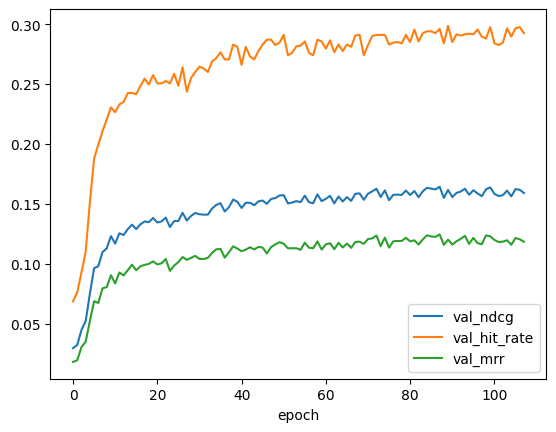

In [15]:
history = extract_validation_history(trainer.logger.experiment.log_dir)
history.drop(columns=['step', 'time']).plot(x="epoch")

## Predict validation

In [16]:
val_users = validation.user_id.unique()
test_users = test.user_id.unique()

train_for_val = train[train.user_id.isin(val_users)]
train_for_test = train[train.user_id.isin(test_users)]

predict_for_val_dataset = MaskedLMPredictionDataset(train_for_val, max_length=MAX_LENGTH)
predict_for_val_loader = DataLoader(
    predict_for_val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

predict_for_test_dataset = MaskedLMPredictionDataset(train_for_test, max_length=MAX_LENGTH)
predict_for_test_loader = DataLoader(
    predict_for_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, collate_fn=PaddingCollateFn())

In [17]:
val_preds = trainer.predict(model=seqrec_module, dataloaders=predict_for_val_loader)
val_recs = preds2recs(val_preds)
print(val_recs.shape)
val_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 271/271 [02:17<00:00, -13.81it/s]
(692460, 3)


,user_id,item_id,prediction
0,3,2409,10.704785
1,3,2035,10.220738
2,3,2451,10.171794
3,3,2809,10.127047
4,3,1591,10.046474


In [18]:
%%time
evaluator = Evaluator(col_time_idx='time_idx')
val_metrics = pd.Series(evaluator.compute_metrics(validation, val_recs, train))
val_metrics

CPU times: user 47.9 s, sys: 15 s, total: 1min 2s
Wall time: 1min 2s


map@10          0.072108
ndcg@10         0.146474
recall@10       0.135591
coverage@10     0.293844
entropy@10     10.826481
novelty@10     11.100533
dtype: float64

In [19]:
evaluator.compute_metrics_by_time_idx(validation, val_recs)

,map@10,ndcg@10,recall@10
0,0.122942,0.162719,0.293533
1,0.079740,0.113996,0.227450
2,0.059789,0.088414,0.184040
3,0.046746,0.070629,0.150868
4,0.037017,0.056621,0.122722
5,0.030199,0.046182,0.100179
6,0.025490,0.039357,0.086330
7,0.021631,0.033498,0.073723
8,0.019194,0.029205,0.062964
9,0.016239,0.024893,0.054097


In [20]:
evaluator.compute_metrics_by_time_idx(validation, val_recs, top_k_gt=True)

,map@10,ndcg@10,recall@10
0,0.122942,0.162719,0.293533
1,0.115214,0.169667,0.260492
2,0.108899,0.171348,0.235008
3,0.102807,0.170111,0.213973
4,0.096829,0.166996,0.195722
5,0.091016,0.162970,0.179799
6,0.085661,0.158856,0.166446
7,0.080700,0.154653,0.154856
8,0.076243,0.150575,0.144645
9,0.072108,0.146474,0.135591


## Predict test

In [21]:
preds_test = trainer.predict(model=seqrec_module, dataloaders=predict_for_test_loader)

test_recs = preds2recs(preds_test)
print(test_recs.shape)
test_recs.head()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████| 271/271 [02:17<00:00, -13.76it/s]
(692470, 3)


,user_id,item_id,prediction
0,1,4134,9.646843
1,1,3998,9.173600
2,1,674,9.032701
3,1,3890,9.023108
4,1,4276,8.947401


In [22]:
%%time
test_metrics = pd.Series(evaluator.compute_metrics(test, test_recs, train))
test_metrics

CPU times: user 48 s, sys: 14.7 s, total: 1min 2s
Wall time: 1min 2s


map@10          0.071020
ndcg@10         0.144633
recall@10       0.133975
coverage@10     0.295017
entropy@10     10.848103
novelty@10     11.119252
dtype: float64

In [23]:
evaluator.compute_metrics_by_time_idx(test, test_recs, )

,map@10,ndcg@10,recall@10
0,0.122178,0.161538,0.290901
1,0.078835,0.113164,0.226797
2,0.058487,0.086725,0.181163
3,0.045554,0.069045,0.147978
4,0.037120,0.056257,0.120669
5,0.029735,0.045847,0.100293
6,0.025606,0.039403,0.085997
7,0.021169,0.032565,0.071194
8,0.018512,0.028439,0.061995
9,0.015722,0.024165,0.052768


In [24]:
evaluator.compute_metrics_by_time_idx(test, test_recs, top_k_gt=True) 

,map@10,ndcg@10,recall@10
0,0.122178,0.161538,0.290901
1,0.114185,0.168433,0.258849
2,0.107404,0.169610,0.232954
3,0.101200,0.168048,0.211710
4,0.095343,0.165079,0.193502
5,0.089594,0.161159,0.177967
6,0.084477,0.157223,0.164828
7,0.079540,0.152915,0.153124
8,0.075117,0.148780,0.142999
9,0.071020,0.144633,0.133975
